In [1]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf

In [24]:
from keras.models import load_model
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras_preprocessing.image import ImageDataGenerator
import pickle

In [3]:
def append_ext(fn):
    return fn.replace(".wav",".png")

# Load du lieu test
testdf=pd.read_csv('data/test.csv',dtype=str)
testdf["slice_file_name"]=testdf["slice_file_name"].apply(append_ext)
test_data_path='data/test/test'

In [4]:
testdf

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100648-1-0-0.png,100648,4.823402,5.471927,2,10,1,car_horn
1,100648-1-1-0.png,100648,8.998279,10.052132,2,10,1,car_horn
2,100648-1-2-0.png,100648,16.699509,17.104837,2,10,1,car_horn
3,100648-1-3-0.png,100648,17.631764,19.253075,2,10,1,car_horn
4,100648-1-4-0.png,100648,25.332994,27.197502,2,10,1,car_horn
...,...,...,...,...,...,...,...,...
2454,99179-9-0-17.png,99179,8.5,12.5,1,8,9,street_music
2455,99179-9-0-19.png,99179,9.5,13.5,1,8,9,street_music
2456,99179-9-0-38.png,99179,19,23,1,8,9,street_music
2457,99179-9-0-53.png,99179,26.5,30.5,1,8,9,street_music


In [12]:
test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
    dataframe=testdf,
    directory=test_data_path,
    x_col="slice_file_name",
    y_col=None,
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(64,64)
)

Found 2459 validated image filenames.


In [13]:
# TInh so buoc test
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

# Tien hanh predict
test_generator.reset()

# Load model da train
model = load_model('model.h5')
pred = model.predict_generator(test_generator,steps=STEP_SIZE_TEST,verbose=1)

C:\Users\Admin\AppData\Local\Temp/ipykernel_21132/3220849960.py:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model.predict_generator(test_generator,steps=STEP_SIZE_TEST,verbose=1)


76/76 [==============================] - 6s 72ms/step


In [22]:
pred

array([[4.09287319e-20, 1.66059732e-01, 2.22941698e-15, ...,
        7.72473235e-23, 2.72373400e-12, 2.51097276e-09],
       [1.05233074e-23, 9.99841213e-01, 1.09058304e-13, ...,
        1.06206119e-17, 3.30743351e-22, 1.58798153e-04],
       [2.25369652e-24, 1.00000000e+00, 1.35442468e-27, ...,
        1.07618787e-23, 1.37971930e-23, 1.68984327e-14],
       ...,
       [8.84466171e-01, 3.25954426e-03, 1.66762099e-02, ...,
        3.41553008e-03, 6.49214344e-05, 8.87668356e-02],
       [4.53875922e-02, 6.15122117e-05, 1.13524618e-02, ...,
        2.87180282e-02, 2.47456882e-07, 9.03241098e-01],
       [1.09461272e-30, 1.00000000e+00, 2.89596552e-33, ...,
        9.05591823e-38, 1.95139646e-29, 1.04500306e-11]], dtype=float32)

In [29]:
# Lay class predict probality lon nhat
predicted_class_indices=np.argmax(pred,axis=1)
predicted_class_indices

array([3, 1, 1, ..., 0, 9, 1], dtype=int64)

In [17]:
len(predicted_class_indices)

2432

In [33]:
print("Real values:\n",testdf.head(10)["class"])

Real values:
 0            car_horn
1            car_horn
2            car_horn
3            car_horn
4            car_horn
5            dog_bark
6            dog_bark
7            dog_bark
8            dog_bark
9    children_playing
Name: class, dtype: object


In [34]:
label={
    '0':'air_conditioner',
    '1':'car_horn',
    '2':'children_playing',
    '3':'dog_bark',
    '4':'drilling',
    '5':'engine_idling',
    '6':'gun_shot',
    '7':'jackhammer',
    '8':'siren',
    '9':'street_music',
}

In [46]:
cm = tf.math.confusion_matrix(labels=testdf["classID"][:-27].astype(int),predictions=np.array(predicted_class_indices))
cm

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[ 58,   0, 106,  31,  15,   3,   3,  39,  19,  26],
       [  0,  74,   2,   1,   0,   0,   0,   0,   0,  18],
       [  5,   2, 213,  28,   4,  12,   0,   2,   9,  25],
       [ 10,   4,  38, 195,  10,   5,   0,   6,   7,  20],
       [ 19,   5,   9,  10, 153,  17,   2,  63,  10,  10],
       [ 20,   0,  14,  14,  46, 129,   0,  18,   4,  16],
       [  1,   0,   0,   7,   0,   0,  85,   0,   0,   0],
       [  4,   0,   2,   1,  40,   5,   1, 201,   0,   2],
       [  5,   4,  19,   7,   0,  29,   0,   0, 169,   7],
       [  1,  16,  21,   8,   7,   6,   0,   4,   8, 223]])>

Text(69.0, 0.5, 'Truth')

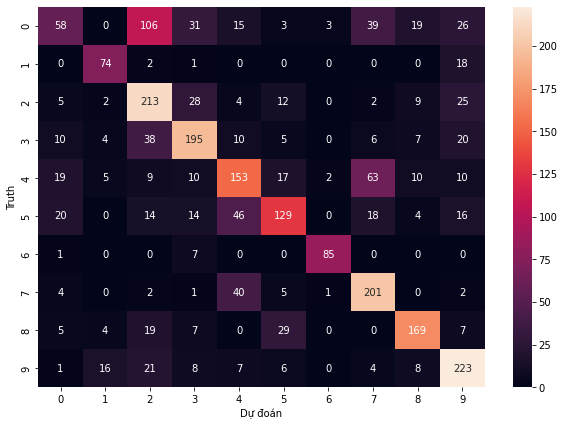

In [49]:
import seaborn as sn
import matplotlib.pyplot as plt

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Dự đoán')
plt.ylabel('Truth')